In [ ]:
# Train multiclass model for classification

import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import classification_report
import torch
import numpy as np

df = pd.read_csv("reddit_sentiment_labeled_5000.csv")
label_map = {"Positive": 0, "Negative": 1, "Suggestion": 2}
df["label"] = df["label"].map(label_map)

dataset = Dataset.from_pandas(df[["text", "label"]])
dataset = dataset.train_test_split(test_size=0.2, seed=42)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_fn(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

tokenized_ds = dataset.map(tokenize_fn, batched=True)

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

training_args = TrainingArguments(
    output_dir="./bert-multiclass-results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    report = classification_report(labels, preds, target_names=list(label_map.keys()), output_dict=True)
    return {
        "accuracy": report["accuracy"],
        "f1_positive": report["Positive"]["f1-score"],
        "f1_negative": report["Negative"]["f1-score"],
        "f1_suggestion": report["Suggestion"]["f1-score"]
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

In [16]:
trainer.save_model("./bert-multiclass-model")
tokenizer.save_pretrained("./bert-multiclass-model")

('./bert-multiclass-model/tokenizer_config.json',
 './bert-multiclass-model/special_tokens_map.json',
 './bert-multiclass-model/vocab.txt',
 './bert-multiclass-model/added_tokens.json',
 './bert-multiclass-model/tokenizer.json')

In [12]:
import praw
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import gensim
from gensim import corpora
from gensim.models import LdaMulticore
from transformers import pipeline
import numpy as np
from minisom import MiniSom 
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [13]:
def initialize_nlp():
    nlp = spacy.load("en_core_web_sm")
    nltk.download("stopwords")
    nltk.download("punkt")
    return nlp

def clean_lda_keywords_with_pos(topic_terms):
    raw_keywords = [kw.split("*")[1].replace('"', '').strip() for kw in topic_terms.split("+")]
    doc = nlp(" ".join(raw_keywords))
    allowed_pos = {"NOUN", "PROPN", "ADJ"}  
    filtered = [token.text for token in doc if token.pos_ in allowed_pos]
    return filtered[:5]

def get_reddit_posts(cache_path="reddit_buyitforlife_posts.csv"):
    if os.path.exists(cache_path):
        print("Loading posts from cached CSV...")
        df = pd.read_csv(cache_path)
        posts = list(zip(df["title"], df["body"]))
    else:
        print("Fetching posts from Reddit API...")
        reddit = praw.Reddit(
            client_id="9ETAXWFx9IHiC7AOh8-APg",
            client_secret="TuskU4_ysvTwaJJ3i9K40HLEiykE9A",
            user_agent="python:brand-sentiment-analyzer:v1.0 (by /u/Soul_Pay4951)"
        )
        subreddit = reddit.subreddit("BuyItForLife")
        posts = []
        for post in subreddit.top(time_filter='all', limit=1000):
            post.comments.replace_more(limit=0)
            comments = [comment.body for comment in post.comments.list()]
            top_comments = " ".join(comments[:3]) 
            title = post.title.strip()
            body = (post.selftext + " " + top_comments).strip()
            posts.append((title, body))

        df = pd.DataFrame(posts, columns=["title", "body"])
        df.to_csv(cache_path, index=False)
        print(f" Saved {len(posts)} posts to {cache_path}")

    return posts


def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  
    text = re.sub(r"\W", " ", text)  
    text = re.sub(r"\s+", " ", text).strip()
    return text


def preprocess_for_lda(text, stop_words):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return tokens

def extract_entities(text, nlp):
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        if ent.label_ in ["ORG", "PRODUCT"]:
            name = ent.text.strip()

            if len(name.split()) > 3:
                continue
            if any(word.lower() in stopwords.words("english") for word in name.split()):
                continue
            if name.isdigit():
                continue

            name = name.title()

            entities.append((name, ent.label_))
    return entities


def perform_topic_modeling(tokenized_posts, num_topics=3):
    dictionary = corpora.Dictionary(tokenized_posts)
    corpus = [dictionary.doc2bow(post) for post in tokenized_posts]
    lda_model = LdaMulticore(
        corpus,
        num_topics=num_topics,
        id2word=dictionary,
        passes=10,
        workers=2
    )
    topics = lda_model.print_topics(num_words=5)
    return topics, lda_model, corpus, dictionary




In [14]:
tokenizer = AutoTokenizer.from_pretrained("./bert-multiclass-model")
model = AutoModelForSequenceClassification.from_pretrained("./bert-multiclass-model")

label_map = {
    0: "POSITIVE",
    1: "NEGATIVE",
    2: "SUGGESTION"
}

def analyze_multiclass_sentiments(texts):
    results = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            probs = F.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
        label = label_map[predicted_class]
        score = probs[0][predicted_class].item()
        results.append({"label": label, "score": round(score, 4)})
    return results

In [15]:
from collections import defaultdict
from difflib import get_close_matches

# valid_brands = {""}


def resolve_to_known_brand(entity_text):
    entity_clean = re.sub(r'[^a-z0-9\s]', '', entity_text.lower().strip())
    tokens = entity_clean.split()
    for word in tokens:
        # if word in valid_brands:
        return word
    match = get_close_matches(entity_clean, valid_brands, n=1, cutoff=0.85)
    return match[0] if match else None

def get_suggestions_by_org(cleaned_posts, sentiments, entity_lists):
    suggestions_by_org = defaultdict(list)
    for (title, body), sentiment, entities in zip(cleaned_posts, sentiments, entity_lists):
        if sentiment['label'] == 'SUGGESTION' and sentiment['score'] > 0.85:
            text = title + " " + body
            for entity, ent_type in entities:
                if ent_type == "ORG":
                    resolved = resolve_to_known_brand(entity)
                    if resolved:
                        suggestions_by_org[resolved].append(text)
    return suggestions_by_org

def compute_sentiment_breakdown_per_org(cleaned_posts, sentiments, entity_lists):
    org_sentiment_count = defaultdict(lambda: {"POSITIVE": 0, "NEGATIVE": 0, "SUGGESTION": 0})
    for (title, body), sentiment, entities in zip(cleaned_posts, sentiments, entity_lists):
        for entity, ent_type in entities:
            if ent_type == "ORG":
                org_sentiment_count[entity][sentiment['label']] += 1
    return org_sentiment_count


In [16]:
class HebbianLearning:
    def __init__(self, topics):
        self.topics = topics
        self.associations = {topic: 0.0 for topic in topics}

    def update(self, topic, sentiment_score):
        learning_rate = 0.1
        if topic in self.associations:
            self.associations[topic] += learning_rate * sentiment_score

    def get_associations(self):
        return self.associations

def cluster_sentiments(senti_vectors):
    if not senti_vectors:
        return None
    data = np.array(senti_vectors)
    som = MiniSom(3, 3, data.shape[1], sigma=0.5, learning_rate=0.5, random_seed=42)
    som.random_weights_init(data)
    som.train_random(data, 100)
    clusters = [som.winner(vec) for vec in data]
    return clusters

In [17]:
from sklearn.metrics import silhouette_score

def visualize_som_silhouette(senti_vectors, clusters):
    if not senti_vectors or not clusters:
        print("SOM: Insufficient data for silhouette score.")
        return None

    data = np.array(senti_vectors)
    labels = [f"{c[0]}-{c[1]}" for c in clusters]
    try:
        sil_score = silhouette_score(data, labels)
    except:
        sil_score = 0

    print(f"SOM Silhouette Score: {sil_score:.4f}")
    plt.figure(figsize=(6, 4))
    plt.bar(['SOM Clustering'], [sil_score], color='darkorange')
    plt.ylabel("Silhouette Score")
    plt.title("SOM Cluster Quality")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    return sil_score


In [18]:
#transformers performance
from sklearn.metrics import classification_report

def visualize_transformer_performance(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    accuracy = report['accuracy']
    f1_macro = report['macro avg']['f1-score']

    print(f"Transformer Accuracy: {accuracy:.4f}")
    print(f"Transformer F1 Score: {f1_macro:.4f}")

    labels = ['Accuracy', 'F1 Score']
    values = [accuracy, f1_macro]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, values, color='mediumseagreen')
    plt.ylim(0, 1)
    plt.title("Transformer Performance")
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
    plt.tight_layout()
    plt.show()
    return accuracy, f1_macro


In [19]:
def visualize_method_comparison(lda_score, som_score, transformer_score):
    methods = ['LDA', 'SOM', 'Transformer']
    scores = [lda_score, som_score, transformer_score]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(methods, scores, color=['cornflowerblue', 'darkorange', 'mediumseagreen'])
    plt.ylabel('Evaluation Metric (Scaled 0-1)')
    plt.title('Method Comparison: Insight Value / Quality Metric')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center')
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()


In [25]:
nlp = initialize_nlp()
stop_words = set(stopwords.words("english"))
posts = get_reddit_posts()
cleaned_posts = [(clean_text(title), clean_text(body)) for title, body in posts]
original_texts = [str(title) + " " + str(body) for title, body in posts]

tokenized_posts = [preprocess_for_lda(title + " " + body, stop_words) for title, body in cleaned_posts]

combined_texts = [title + " " + body for title, body in cleaned_posts]

sentiments = analyze_multiclass_sentiments(original_texts)


brands_products = [extract_entities(text, nlp) for text in combined_texts]
print("\nExtracted Entities (Brands/Products):")
for bp in brands_products:
    if bp:
        print(bp)

tokenized_posts = [preprocess_for_lda(text, stop_words) for text in combined_texts]
topics, lda_model, corpus, dictionary = perform_topic_modeling(tokenized_posts, num_topics=8)
# print("\nTopics from LDA:")
# for topic in topics:
#     print(topic)

topic_strs = [", ".join([word for word, prob in lda_model.show_topic(i)]) for i in range(lda_model.num_topics)]



def plot_topic_sentiment_distribution(topic_sentiment_counts):
    topics = list(topic_sentiment_counts.keys())
    pos = [topic_sentiment_counts[t]["POSITIVE"] for t in topics]
    neg = [topic_sentiment_counts[t]["NEGATIVE"] for t in topics]
    sug = [topic_sentiment_counts[t]["SUGGESTION"] for t in topics]

    x = np.arange(len(topics))
    width = 0.25

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, pos, width, label='Positive')
    plt.bar(x, neg, width, label='Negative')
    plt.bar(x + width, sug, width, label='Suggestion')


    plt.title("Sentiment Distribution Across LDA Topics", fontsize=14)
    plt.xlabel("LDA Topic ID", fontsize=12)
    plt.ylabel("Number of Posts", fontsize=12)
    plt.xticks(x, topics)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_hebbian_scores(hebbian_scores, save_path="figures/hebbian_scores.png"):

    topics = list(hebbian_scores.keys())
    scores = list(hebbian_scores.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(topics)), scores, color='skyblue')
    plt.axhline(0, color='black', linewidth=1)

    topic_labels = [f"Topic {i}" for i in range(len(topics))]
    plt.xticks(rotation=45, ha='right', fontsize=10)

    plt.title("Hebbian Learning — Sentiment Strength by Topic", fontsize=14)
    plt.ylabel("Hebbian Score", fontsize=12)

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    


def compute_topic_sentiment_counts(lda_model, corpus, sentiments):
    topic_sentiment_counts = defaultdict(lambda: {"POSITIVE": 0, "NEGATIVE": 0, "SUGGESTION": 0})
    for i, bow in enumerate(corpus):
        topic_distribution = lda_model.get_document_topics(bow)
        if topic_distribution:
            dominant_topic = max(topic_distribution, key=lambda x: x[1])[0]
            sentiment_label = sentiments[i]["label"]
            topic_sentiment_counts[dominant_topic][sentiment_label] += 1
    return topic_sentiment_counts

def assign_posts_to_lda_topics(lda_model, corpus, original_texts):
    topic_to_posts = defaultdict(list)
    for i, bow in enumerate(corpus):
        topic_distribution = lda_model.get_document_topics(bow)
        if topic_distribution:
            dominant_topic = max(topic_distribution, key=lambda x: x[1])[0]
            topic_to_posts[dominant_topic].append(original_texts[i])
    return topic_to_posts




# print(summaries)

# print("\nHebbian Associations:")
# for topic, assoc in hebbian.get_associations().items():
    # print(f"{topic}: {assoc:.4f}")




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vineethmariappan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vineethmariappan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading posts from cached CSV...

Extracted Entities (Brands/Products):
[('200W', 'PRODUCT')]
[('Nasa', 'ORG')]
[('Wal Mart', 'ORG')]
[('Stanley Thermos', 'ORG')]
[('Un', 'ORG')]
[('Toyota', 'ORG'), ('Toyota', 'ORG'), ('Toyota', 'ORG'), ('Toyota', 'ORG')]
[('Lincoln', 'ORG'), ('Lincoln', 'ORG')]
[('Denim Selvedge Denim', 'ORG'), ('Nudie', 'ORG'), ('Nudie', 'ORG')]
[('Gen1', 'ORG')]
[('Toyota', 'ORG')]
[('Ge', 'ORG')]
[('Google', 'ORG')]
[('Nittany33', 'ORG')]
[('Toyota', 'ORG')]
[('Merrell', 'ORG')]
[('Sm58', 'PRODUCT')]
[('Ford', 'ORG')]
[('Fzj80 Rcr', 'ORG')]
[('Navy', 'ORG')]
[('Navy', 'ORG')]
[('X200B', 'ORG')]
[('Samsung', 'ORG')]
[('Gm', 'ORG')]
[('X200B Edit2', 'ORG'), ('X200B', 'ORG')]
[('328K', 'ORG')]
[('Microsoft Usb', 'ORG')]
[('000 00', 'PRODUCT')]
[('Ge', 'ORG')]
[('Miller', 'ORG')]
[('Dab', 'ORG')]
[('Miller', 'ORG')]
[('Sony', 'ORG')]
[('Microsoft', 'ORG'), ('Ps 2', 'ORG')]
[('Pyrex', 'ORG')]
[('Toyota', 'ORG')]
[('Sec', 'ORG')]
[('740 940', 'PRODUCT')]
[('Miller', 'ORG

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


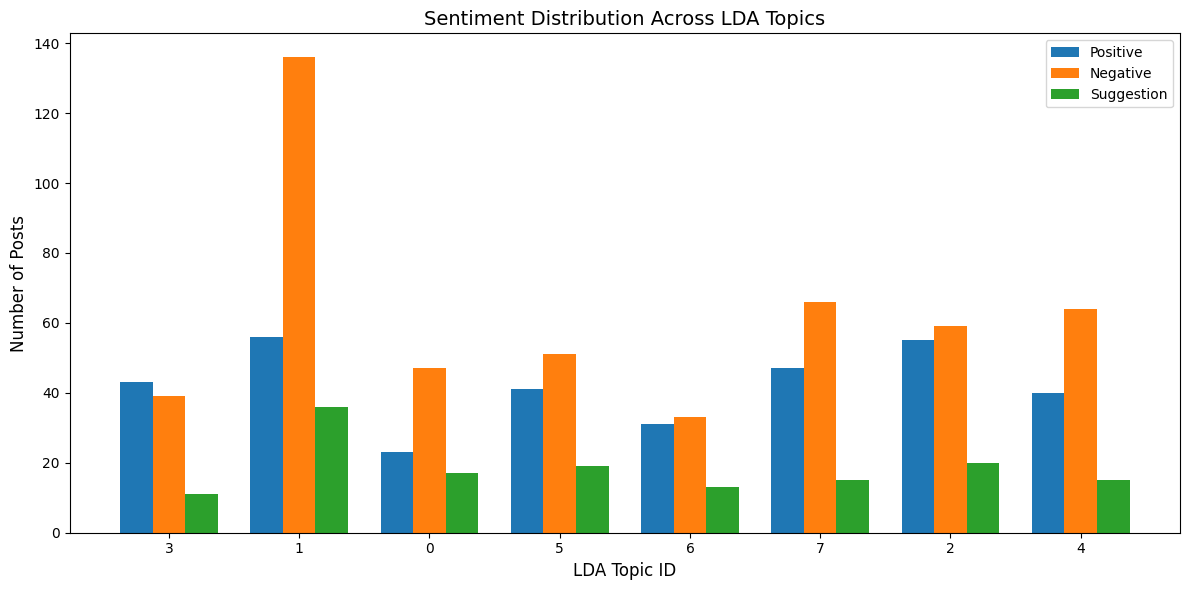

In [23]:
topic_sentiment_counts = compute_topic_sentiment_counts(lda_model, corpus, sentiments)
topic_to_posts = assign_posts_to_lda_topics(lda_model, corpus, original_texts)

plot_topic_sentiment_distribution(topic_sentiment_counts)


def clean_example_post(post):
    post = re.sub(r'\s+', ' ', post.strip())  
    post = re.sub(r"[^a-zA-Z0-9,.!?'\"]+", ' ', post) 
    sentences = re.split(r'(?<=[.!?])\s+', post) 

    
    for s in sentences:
        s = s.strip()
        if 50 < len(s) < 200 and any(word in s.lower() for word in ['suggest', 'recommend', 'quality', 'bought', 'used']):
            return s

    for s in sentences:
        if 40 < len(s) < 200:
            return s

    return post[:140] + "..."

def interpret_cluster(cluster_coord):
    x, y = cluster_coord
    if y == 0 and x <= 1:
        return "Mostly Positive"
    elif y == 2:
        return "Suggestion Heavy"
    elif y == 1:
        return "Mixed Sentiment"
    else:
        return "Mostly Negative"




def generate_user_friendly_summary(topic_id, keywords, topic_string, sentiment_counts, example_posts=None, cluster_counts=None):
    pos = sentiment_counts.get("POSITIVE", 0)
    neg = sentiment_counts.get("NEGATIVE", 0)
    sug = sentiment_counts.get("SUGGESTION", 0)
    total = pos + neg + sug
    if total == 0:
        return None

    if neg > pos and neg > sug:
        insight = "Users are expressing dissatisfaction with this topic."
    elif sug > pos and sug > neg:
        insight = "Users are sharing a lot of suggestions here."
    elif pos > neg and pos > sug:
        insight = "This topic is receiving mostly positive feedback."
    else:
        insight = "Mixed feedback observed."

    hebbian_scores = hebbian.get_associations()
    
    top_clusters = []
    for cluster, sentiment_list in topic_cluster_distribution[topic_id].items():
        label = label_cluster(sentiment_list)
        top_clusters.append({
            "cluster": str(cluster),
            "label": label,
            "count": len(sentiment_list)
        })

    top_clusters = sorted(top_clusters, key=lambda x: x["count"], reverse=True)[:2]


    return {
        "topic_id": topic_id,
        "keywords": keywords,
        "insight": insight,
        "positive": pos,
        "negative": neg,
        "suggestion": sug,
        "hebbian_score": round(hebbian_scores.get(topic_string, 0.0), 4),
        "top_clusters": top_clusters,
        "example_posts": [clean_example_post(post) for post in example_posts[:2]]
    }


senti_vectors = []
for res in sentiments:
    if res['label'] == "positive":
        senti_vectors.append([res['score'], 0.0, 0.0])
    elif res['label'] == "negative":
        senti_vectors.append([0.0, res['score'], 0.0])
    else:
        senti_vectors.append([0.0, 0.0, res['score']])
clusters = cluster_sentiments(senti_vectors)




SOM Clusters:


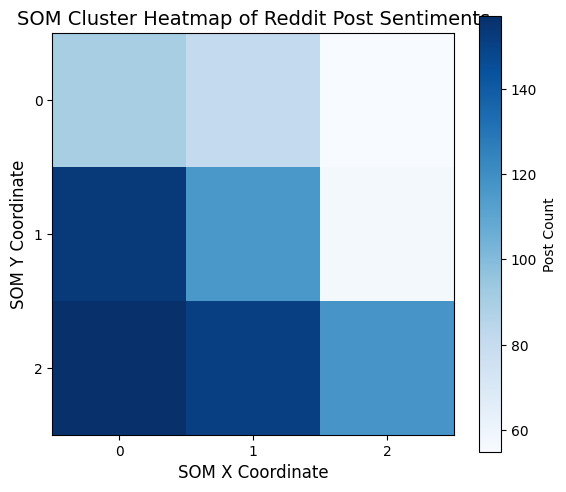

In [22]:
print("\nSOM Clusters:")


cluster_counts = {}
for cluster in clusters:
    cluster_counts[cluster] = cluster_counts.get(cluster, 0) + 1

grid_size = 3
heatmap = np.zeros((grid_size, grid_size))
for (x, y), count in cluster_counts.items():
    heatmap[x, y] = count

plt.figure(figsize=(6, 6))
plt.imshow(heatmap, cmap='Blues', interpolation='nearest')
plt.title("SOM Cluster Heatmap of Reddit Post Sentiments", fontsize=14)
plt.xlabel("SOM X Coordinate", fontsize=12)
plt.ylabel("SOM Y Coordinate", fontsize=12)
plt.colorbar(label="Post Count", shrink=0.8)
plt.xticks(range(grid_size), fontsize=10)
plt.yticks(range(grid_size), fontsize=10)
plt.tight_layout()
plt.tight_layout(pad=2)
plt.savefig("figures/som_cluster_distribution.png")  
plt.show()

def label_cluster(cluster_posts_sentiments):
    counts = {"POSITIVE": 0, "NEGATIVE": 0, "SUGGESTION": 0}
    for s in cluster_posts_sentiments:
        counts[s["label"]] += 1
    max_label = max(counts, key=counts.get)
    if counts[max_label] == counts["POSITIVE"] == counts["NEGATIVE"] == counts["SUGGESTION"]:
        return "Mixed Sentiment"
    return {
        "POSITIVE": "Mostly Positive",
        "NEGATIVE": "Mostly Negative",
        "SUGGESTION": "Suggestion Heavy"
    }.get(max_label, "Mixed Sentiment")


topic_assignments = [lda_model[corpus[i]] for i in range(len(corpus))]
post_to_topic = [max(topic_probs, key=lambda x: x[1])[0] for topic_probs in topic_assignments]


topic_cluster_distribution = defaultdict(lambda: defaultdict(list))

for i, topic_id in enumerate(post_to_topic):
    cluster = clusters[i]
    sentiment_label = sentiments[i]["label"]
    topic_cluster_distribution[topic_id][cluster].append({"label": sentiment_label})



org_sentiment_distribution = compute_sentiment_breakdown_per_org(cleaned_posts, sentiments, brands_products)
summaries = []
hebbian = HebbianLearning(topic_strs)
topic_post_counts = defaultdict(int)

for i, bow in enumerate(corpus):
    topic_distribution = lda_model.get_document_topics(bow)
    if topic_distribution:
        dominant_topic = max(topic_distribution, key=lambda x: x[1])[0]
        topic_str = topic_strs[dominant_topic]

        sentiment = sentiments[i]
        label_weights = {
            "POSITIVE": 1.0,
            "NEGATIVE": -1.0,
            "SUGGESTION": 0.5
        }

        label = sentiment["label"].upper()
        score = label_weights.get(label, 0.0) * sentiment["score"]
        hebbian.update(topic_str, score)
        topic_post_counts[topic_str] += 1


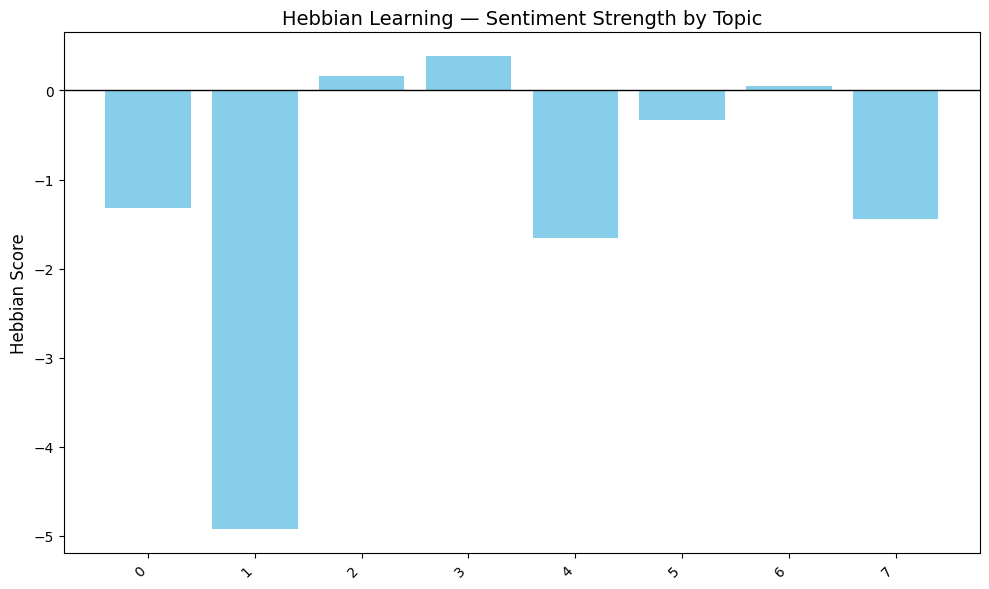

In [21]:
hebbian_scores = hebbian.get_associations()
plot_hebbian_scores(hebbian_scores)



In [36]:
for topic_id, topic_info in topics:
    keywords = clean_lda_keywords_with_pos(topic_info)
    topic_string = topic_strs[topic_id]
    sentiment_counts = topic_sentiment_counts.get(topic_id, {})
    example_posts = topic_to_posts.get(topic_id, [])
    cluster_counts = topic_cluster_distribution.get(topic_id, {})

    summary = generate_user_friendly_summary(
        topic_id,
        keywords,
        topic_string,
        sentiment_counts,
        example_posts=example_posts[:2],
        cluster_counts=cluster_counts
    )
    if summary:
        summaries.append(summary)



In [40]:
print(summaries)

['the airbnb i m staying in has a microwave from june 1984 hey i had that same microwave growing up i m convinced that everything ge made pre 88 was made to survive a nuclear apocalypse how do you know it s june is there one of those metal production tags when you open the door like on a car', {'topic_id': 0, 'keywords': ['gameboy', 'old', 'one'], 'insight': 'Users are expressing dissatisfaction with this topic.', 'positive': 23, 'negative': 47, 'suggestion': 17, 'hebbian_score': 0.0, 'top_clusters': [{'cluster': '(2, 1)', 'label': 'Mostly Negative', 'count': 17}, {'cluster': '(2, 0)', 'label': 'Mostly Negative', 'count': 15}], 'example_posts': ['I used to have one with the pop up headlights and had to replace the mechanism that popped them up twice in 6 years.', 'Original Game Boy still works like a charm How often do you use your Gameboy french translator?']}, {'topic_id': 1, 'keywords': ['voyager', 'banned'], 'insight': 'Users are expressing dissatisfaction with this topic.', 'posit

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

def summarize_suggestions(suggestions_by_org, num_summary_sentences=3):
    summary_by_org = {}
    for org, suggestions in suggestions_by_org.items():
        if not suggestions:
            continue
        clean_suggestions = [re.sub(r'\s+', ' ', s.strip()) for s in suggestions]
        vectorizer = TfidfVectorizer(stop_words='english')
        X = vectorizer.fit_transform(clean_suggestions)
        n_clusters = min(3, len(clean_suggestions))
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X)
        summary = []
        for i in range(n_clusters):
            cluster_indices = (kmeans.labels_ == i).nonzero()[0]
            if len(cluster_indices) > 0:
                first_comment = clean_suggestions[cluster_indices[0]]
                summary.append(first_comment)
        summary_by_org[org] = summary[:num_summary_sentences]
    return summary_by_org
    
def get_lda_topics_per_org(suggestions_by_org):
    org_topics = {}
    for org, suggestions in suggestions_by_org.items():
        if len(suggestions) < 3:
            continue
        tokenized = [word_tokenize(clean_text(s)) for s in suggestions]
        dictionary = corpora.Dictionary(tokenized)
        corpus = [dictionary.doc2bow(text) for text in tokenized]
        lda_model = LdaMulticore(corpus, num_topics=2, id2word=dictionary, passes=5, workers=1)
        topics = lda_model.print_topics(num_words=4)
        org_topics[org] = topics
    return org_topics


def assign_clusters_to_orgs(brands_products, clusters):
    org_clusters = defaultdict(list)

    for i, entities in enumerate(brands_products):
        for entity, ent_type in entities:
            if ent_type == "ORG":
                org_clusters[entity].append(clusters[i])

    return org_clusters



In [27]:
from collections import Counter
def sentiment_breakdown_per_som_cluster(clusters, sentiments):
    cluster_stats = defaultdict(lambda: {"POSITIVE": 0, "NEGATIVE": 0, "SUGGESTION": 0})
    for clust, sent in zip(clusters, sentiments):
        label = sent["label"]
        cluster_stats[clust][label] += 1
    return cluster_stats


In [34]:
suggestions_by_org = get_suggestions_by_org(cleaned_posts, sentiments, brands_products)
org_topics = get_lda_topics_per_org(suggestions_by_org)
cluster_sentiments_list = sentiment_breakdown_per_som_cluster(clusters, sentiments)

        
summarized = summarize_suggestions(suggestions_by_org)

        
print("\nLDA Topics Per Organization:")
for org, topics in org_topics.items():
    print(f"\n{org}:")
    for topic in topics:
        print(f"  - {topic}")
        
print("\nSentiment Breakdown Per SOM Cluster:")
for cluster, breakdown in cluster_sentiments_list.items():
    print(f"Cluster {cluster}:")
    for label, count in breakdown.items():
        print(f"  {label}: {count}")

org_clusters = assign_clusters_to_orgs(brands_products, clusters)

for org, cluster_list in org_clusters.items():
    print(f"\n{org}:")
    counts = defaultdict(int)
    for cl in cluster_list:
        counts[cl] += 1
    for cluster, count in counts.items():
        print(f"  Cluster {cluster}: {count} posts")




LDA Topics Per Organization:

Sentiment Breakdown Per SOM Cluster:
Cluster (2, 1):
  POSITIVE: 31
  NEGATIVE: 108
  SUGGESTION: 12
Cluster (2, 2):
  POSITIVE: 48
  NEGATIVE: 55
  SUGGESTION: 14
Cluster (1, 1):
  POSITIVE: 43
  NEGATIVE: 42
  SUGGESTION: 31
Cluster (1, 0):
  POSITIVE: 54
  NEGATIVE: 64
  SUGGESTION: 35
Cluster (0, 1):
  POSITIVE: 29
  NEGATIVE: 45
  SUGGESTION: 7
Cluster (2, 0):
  POSITIVE: 53
  NEGATIVE: 94
  SUGGESTION: 10
Cluster (0, 2):
  POSITIVE: 22
  NEGATIVE: 22
  SUGGESTION: 11
Cluster (0, 0):
  POSITIVE: 37
  NEGATIVE: 32
  SUGGESTION: 21
Cluster (1, 2):
  POSITIVE: 19
  NEGATIVE: 33
  SUGGESTION: 5

Nasa:
  Cluster (2, 1): 2 posts

Wal Mart:
  Cluster (1, 1): 1 posts
  Cluster (2, 1): 1 posts

Stanley Thermos:
  Cluster (1, 0): 1 posts

Un:
  Cluster (2, 1): 1 posts

Toyota:
  Cluster (2, 0): 7 posts
  Cluster (0, 1): 3 posts
  Cluster (2, 1): 2 posts
  Cluster (2, 2): 7 posts
  Cluster (1, 0): 7 posts
  Cluster (0, 0): 1 posts
  Cluster (1, 2): 2 posts
  Cl

In [20]:
from gensim.models.coherencemodel import CoherenceModel

def visualize_lda_coherence(lda_model, tokenized_posts, dictionary):
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_posts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"LDA Coherence Score: {coherence_score:.4f}")

    plt.figure(figsize=(6, 4))
    plt.bar(['LDA Topic Modeling'], [coherence_score], color='cornflowerblue')
    plt.ylabel("Coherence Score (c_v)")
    plt.title("LDA Coherence Score")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    return coherence_score


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

LDA Coherence Score: 0.5005


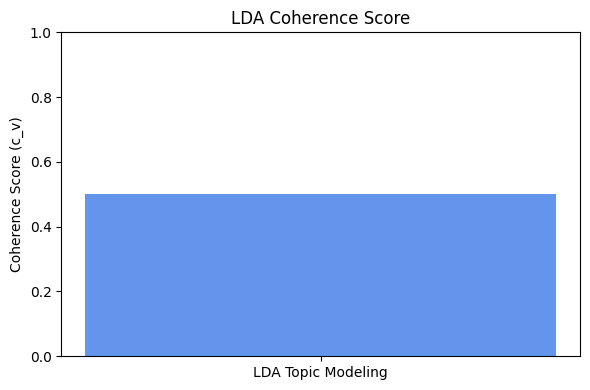

SOM Silhouette Score: 0.6311


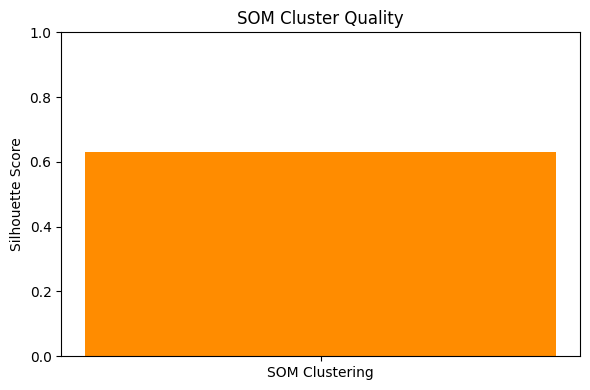

In [12]:
lda_score = visualize_lda_coherence(lda_model, tokenized_posts, dictionary)
som_score = visualize_som_silhouette(senti_vectors, clusters)
